**Setup Enviroment**

In [2]:
!pip install transformers==4.37.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 108.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [3]:
import numpy as np
import os
import pandas as pd

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification, XLMRobertaTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

# Specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


**Load Data**


In [4]:
data=pd.read_excel("/content/Merged _Fakenews_Data.xlsx")
data.head(10)

,Actual_Post,Label
0,መንግስት ከልምድ ተመሮ ምንም ጥቅምና አትኩሮት የሌለውን መግለጫ በመግለጫ...,Fake
1,ወይ ጉድ! ስለ ዜግነት በቅጡ ሳይረዱ ዜግነት ሰጪና ከልካይ የፖለቲካ መሪ...,Fake
2,አብሮነት በመከባበር ላይ የተመሰረተ መሆን አለበት። ኦሮሚያ ውስጥ የምትኖ...,Fake
3,እንኳን አሁን ወያኔም እያለ የህዝቦች ሁሉ ጠላት ነፍጠኛዉ ነው ብዬ ነበር...,Fake
4,"እንደዚህ እንደዚያ የሚያረጉን ""ኃይሎች"" እያሉ መንግስት ነን ባዮች ችግሮ...",Fake
5,እሺ ሰላማዊና ሚዘናዊ ዉይይታችንን ስንቀጥል፡ እዉነት እነዚህ የዜግነት ፖ...,Fake
6,የአማራ ድርጅቶች አብሮ ለመስራት መግባባታቸው ለበጎ ከሆነ እሰየው ነዉ። ...,Fake
7,እስኪ እንደው እንኹዋን #OMN ቀርቶ ለሰው ልጆች ሰላም፡ ፍትህና እኩልነ...,Fake
8,አይ አብይ አህመድ! መቸም ያንተን ታሪክ በቅርቡ እናያለን። በዓመታት የኦ...,Fake
9,ጊዜ የማይለዉጣቹ ሞኞች፡ አላዋቂዎችና አስመሳዮች (ለምሳሌ ዋናወቹ ታማኝና...,Fake


In [5]:
import nltk
import re

In [6]:
space_pattern = '\\s+'
url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
englishword_num ='[a-zA-Z]|[0-9]+'
AmhPunc='[፤።፡፣:,.?/()•“”*፨]+'
special_char = "[፥@#$%^&=?×!,;:_.(){}`'+*<>\"¤—„\\® ̄™¡¡\\x10»€«·‘0e1b§”¬¦...\"\"f÷\\~ ̈©±¥£¶–°• ̃’“|]"
geez_number='[፩፪፫፬፭፮፯፰፱፲፳፴፵፶፷፸፹፺፻] ' # for removing geez number
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                 u"\U0001F1E0-\U0001F1FF"  # flags
                                 u"\U00002702-\U000027B0"
                                 u"\U000024C2-\U0001F251"
                                 "]+", flags=re.UNICODE)
haa='[ሃ]'; he='[ሐ]'; hu='[ሑ]'; hi='[ሒ]'; ha='[ሓ]'; hie='[ሔ]'; h='[ሕ]'; ho='[ሖ]'; he1='[ኀ]'; hu1='[ኁ]'; hi1='[ኂ]'; ha1='[ኃ]'; hie1='[ኄ]'; h1='[ኅ]'; ho1='[ኆ]';
se='[ሠ]'; su='[ሡ]'; si='[ሢ]'; sa='[ሣ]'; sie='[ሤ]'; s='[ሥ]'; so='[ሦ]';
aa1='[ኣ]'; ae='[ዐ]'; au='[ዑ]'; ai='[ዒ]'; aa='[ዓ]'; aie='[ዔ]'; e='[ዕ]'; ao='[ዖ]';
tse='[ጸ]'; tsu='[ጹ]'; tsi='[ጺ]'; tsa='[ጻ]'; tsie='[ጼ]'; ts='[ጽ]'; tso='[ጾ]';

In [7]:
corpus=[]
for i in range(0,len(data)):
    Clean_text = re.sub(url_regex,'', str(data['Actual_Post'][i]))
    Clean_text = re.sub(AmhPunc,' ',Clean_text)
    Clean_text=re.sub(special_char,' ',Clean_text)
    Clean_text= re.sub(englishword_num,'',Clean_text)
    Clean_text= re.sub(r'(.)\1+', r'\1\1',Clean_text) #removingelongation in text
    Clean_text = RE_EMOJI.sub(r'', Clean_text)
    Clean_text =re.sub(geez_number,'',Clean_text)
    Clean_text=re.sub('-','',Clean_text)
    Clean_text=re.sub(r'<[^>]*>','', Clean_text)
    Clean_text = Clean_text.replace("\\", "");
    Clean_text = Clean_text.replace("[", "");
    Clean_text = Clean_text.replace("]", "");
    Clean_text = emoji_pattern.sub(r'', Clean_text)
    Clean_text = re.sub(space_pattern,' ',Clean_text)
    ##################################################
    Clean_text= re.sub(he,'ሀ',Clean_text);
    Clean_text= re.sub(hu,'ሁ',Clean_text);
    Clean_text= re.sub(hi,'ሂ',Clean_text);
    Clean_text= re.sub(ha,'ሀ',Clean_text);
    Clean_text= re.sub(hie,'ሄ',Clean_text);
    Clean_text= re.sub(h,'ህ',Clean_text);
    Clean_text= re.sub(ho,'ሆ',Clean_text);
    Clean_text= re.sub(haa,'ሀ',Clean_text);
    #######################################################
    Clean_text= re.sub(he1,'ሀ',Clean_text)
    Clean_text= re.sub(hu1,'ሁ',Clean_text)
    Clean_text= re.sub(hi1,'ሂ',Clean_text)
    Clean_text= re.sub(ha1,'ሀ',Clean_text)
    Clean_text= re.sub(hie1,'ሄ',Clean_text)
    Clean_text= re.sub(h1,'ህ',Clean_text)
    Clean_text= re.sub(ho1,'ሆ',Clean_text)
    ##########################################################
    Clean_text= re.sub(se,'ሰ',Clean_text)
    Clean_text= re.sub(su,'ሱ',Clean_text)
    Clean_text= re.sub(si,'ሲ',Clean_text)
    Clean_text= re.sub(sa,'ሳ',Clean_text)
    Clean_text= re.sub(sie,'ሴ',Clean_text)
    Clean_text= re.sub(s,'ስ', Clean_text)
    Clean_text= re.sub(so,'ሶ',Clean_text)
    ###################################################
    Clean_text= re.sub(ae,'አ',Clean_text)
    Clean_text= re.sub(au,'ኡ',Clean_text)
    Clean_text= re.sub(ai,'ኢ',Clean_text)
    Clean_text= re.sub(aa,'አ',Clean_text)
    Clean_text= re.sub(aie,'ኤ',Clean_text)
    Clean_text= re.sub(e,'እ',Clean_text)
    Clean_text= re.sub(ao,'ኦ',Clean_text)
    Clean_text= re.sub(aa1,'አ',Clean_text)
    #############################################
    Clean_text= re.sub(tse,'ፀ',Clean_text)
    Clean_text= re.sub(tsu,'ፁ',Clean_text)
    Clean_text= re.sub(tsi,'ፂ',Clean_text)
    Clean_text= re.sub(tsa,'ፃ',Clean_text)
    Clean_text= re.sub(tsie,'ፄ',Clean_text)
    Clean_text= re.sub(ts,'ፅ',Clean_text)
    Clean_text= re.sub(tso,'ፆ',Clean_text)
    Clean_text= Clean_text.split()
    Clean_text = ' '.join(Clean_text)
    corpus.append(Clean_text)

In [8]:
data.head(10)

,Actual_Post,Label
0,መንግስት ከልምድ ተመሮ ምንም ጥቅምና አትኩሮት የሌለውን መግለጫ በመግለጫ...,Fake
1,ወይ ጉድ! ስለ ዜግነት በቅጡ ሳይረዱ ዜግነት ሰጪና ከልካይ የፖለቲካ መሪ...,Fake
2,አብሮነት በመከባበር ላይ የተመሰረተ መሆን አለበት። ኦሮሚያ ውስጥ የምትኖ...,Fake
3,እንኳን አሁን ወያኔም እያለ የህዝቦች ሁሉ ጠላት ነፍጠኛዉ ነው ብዬ ነበር...,Fake
4,"እንደዚህ እንደዚያ የሚያረጉን ""ኃይሎች"" እያሉ መንግስት ነን ባዮች ችግሮ...",Fake
5,እሺ ሰላማዊና ሚዘናዊ ዉይይታችንን ስንቀጥል፡ እዉነት እነዚህ የዜግነት ፖ...,Fake
6,የአማራ ድርጅቶች አብሮ ለመስራት መግባባታቸው ለበጎ ከሆነ እሰየው ነዉ። ...,Fake
7,እስኪ እንደው እንኹዋን #OMN ቀርቶ ለሰው ልጆች ሰላም፡ ፍትህና እኩልነ...,Fake
8,አይ አብይ አህመድ! መቸም ያንተን ታሪክ በቅርቡ እናያለን። በዓመታት የኦ...,Fake
9,ጊዜ የማይለዉጣቹ ሞኞች፡ አላዋቂዎችና አስመሳዮች (ለምሳሌ ዋናወቹ ታማኝና...,Fake


In [9]:
# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1)
data['Label'] = pd.get_dummies(data.Label)['Fake']

([<matplotlib.patches.Wedge at 0x7814ff70c6b0>,
 [Text(-1.198656508887723, 0.056767717067856355, 'Fake'),
  Text(1.19865651385051, -0.05676761227797186, 'Real')],
 [Text(-0.6992162968511717, 0.0331145016229162, '48.5%'),
  Text(0.6992162997461308, -0.03311444049548358, '51.5%')])

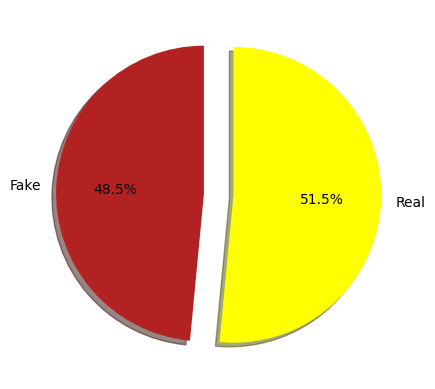

In [10]:
# Checking if our data is well balanced
label_size = [data['Label'].sum(),len(data['Label'])- data['Label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','yellow'],startangle=90,shadow=True,labels=['Fake','Real'],autopct='%1.1f%%')

In [11]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['Actual_Post'], data['Label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Label'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

**AfriBERTa Fine Tunning**

In [13]:
from transformers import XLMRobertaModel, XLMRobertaTokenizer,AutoTokenizer, AutoModelForTokenClassification

In [14]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = XLMRobertaModel.from_pretrained('castorini/afriberta_large')
tokenizer = XLMRobertaTokenizer.from_pretrained('castorini/afriberta_large')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/503M [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Tokenize text Data

Text(0, 0.5, 'Number of texts')

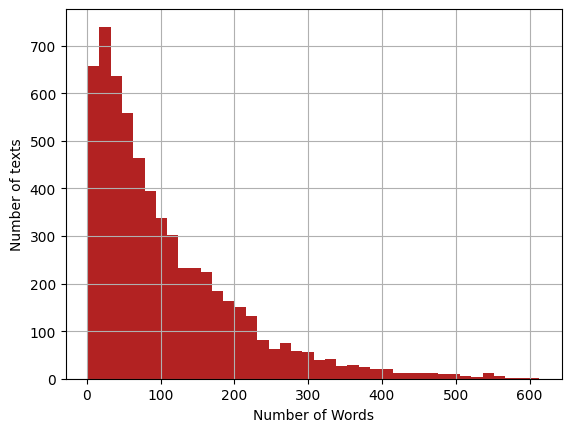

In [15]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(Actual_Post.split()) for Actual_Post in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [16]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    padding='max_length',
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    padding='max_length',
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    padding='max_length',
    truncation=True
)

In [17]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [18]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [19]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [20]:
import torch
import torch.nn as nn
from torch.optim import Adam

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        # Dynamically get hidden size from BERT config
        hidden_size = bert.config.hidden_size
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, 512)  # Dynamic hidden size
        self.fc2 = nn.Linear(512, 2)
        print(f"BERT hidden size: {hidden_size}")

    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask).last_hidden_state[:, 0, :]
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x  # Return raw logits

model = BERT_Arch(bert)
model = model.to(device)  # Move to GPU
print(f"Model moved to {device}")


BERT hidden size: 768
Model moved to cuda


In [21]:
# Unfreeze BERT parameters for fine-tuning
for param in bert.parameters():
    param.requires_grad = True

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0.01)  # Added weight_decay


# Loss function
cross_entropy = nn.CrossEntropyLoss()

# Epochs
epochs = 5

In [22]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # Move batch to GPU
        sent_id, mask, labels = batch
        sent_id = sent_id.to(device)
        mask = mask.to(device)
        labels = labels.to(device).long()

        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_accuracy += np.sum(np.argmax(preds, axis=1) == labels.cpu().numpy())

    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_accuracy / len(train_labels)

    return avg_loss, avg_accuracy


In [23]:
def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # Move batch to GPU
        sent_id, mask, labels = batch
        sent_id = sent_id.to(device)
        mask = mask.to(device)
        labels = labels.to(device).long()

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_accuracy += np.sum(np.argmax(preds, axis=1) == labels.cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    avg_accuracy = total_accuracy / len(val_labels)

    return avg_loss, avg_accuracy


In [24]:
# Early stopping parameters
patience = 3  # Stop if no improvement for 3 epochs
best_val_loss = float('inf')
patience_counter = 0

In [25]:
# Initialize training parameters
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Early stopping parameters
patience = 3  # Stop if no improvement for 3 epochs
patience_counter = 0

# Training loop
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, train_accuracy = train()
    valid_loss, valid_accuracy = evaluate()

    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
        patience_counter = 0  # Reset counter
        print(f"✓ New best model saved!")
    else:
        patience_counter += 1
        print(f"✗ No improvement ({patience_counter}/{patience})")

    # Store metrics
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    # Print metrics
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Training Accuracy: {train_accuracy:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping triggered at epoch {epoch + 1}")
        print(f"Training stopped early. Best model was saved at epoch {epoch + 1 - patience}")
        break

print("\n" + "="*50)
print("Training Complete!")
print(f"Best validation loss: {best_valid_loss:.4f}")
print("="*50)



 Epoch 1 / 5
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...
✓ New best model saved!

Training Loss: 0.416
Validation Loss: 0.247
Training Accuracy: 0.839
Validation Accuracy: 0.917

 Epoch 2 / 5
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...
✓ New best model saved!

Training Loss: 0.244
Validation Loss: 0.233
Training Accuracy: 0.912
Validation Accuracy: 0.912

 Epoch 3 / 5
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...
✓ New best model saved!

Training Loss: 0.215
Validation Loss: 0.209
Training Accuracy: 0.926
Validation Accuracy: 0.925

 Epoch 4 / 5
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    189.

Evaluating...
✓ New best model saved!

Training Loss: 0.195
Validation Loss: 0.198
Training Accuracy: 0.934
Validation Accuracy: 0.928

 Epoch 5 / 5
  Batch    50  of    189.
  Batch   100  of    189.
  Batch   150  of    1

In [26]:
# Find the epoch with best validation loss
best_epoch_idx = valid_losses.index(min(valid_losses))
best_epoch_num = best_epoch_idx + 1

print("\n" + "="*60)
print("BEST MODEL STATISTICS")
print("="*60)
print(f"Best validation loss occurred at epoch: {best_epoch_num}")
print(f"Best validation loss: {min(valid_losses):.4f}")
print(f"Corresponding validation accuracy: {valid_accuracies[best_epoch_idx]:.4f}")
print(f"Corresponding training loss: {train_losses[best_epoch_idx]:.4f}")
print(f"Corresponding training accuracy: {train_accuracies[best_epoch_idx]:.4f}")
print("="*60)



BEST MODEL STATISTICS
Best validation loss occurred at epoch: 4
Best validation loss: 0.1980
Corresponding validation accuracy: 0.9281
Corresponding training loss: 0.1954
Corresponding training accuracy: 0.9336


In [27]:
import numpy as np
from sklearn.metrics import classification_report
import torch

# Move test tensors to GPU
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)

model.eval()
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))


              precision    recall  f1-score   support

       False       0.92      0.95      0.93       667
        True       0.94      0.91      0.93       628

    accuracy                           0.93      1295
   macro avg       0.93      0.93      0.93      1295
weighted avg       0.93      0.93      0.93      1295



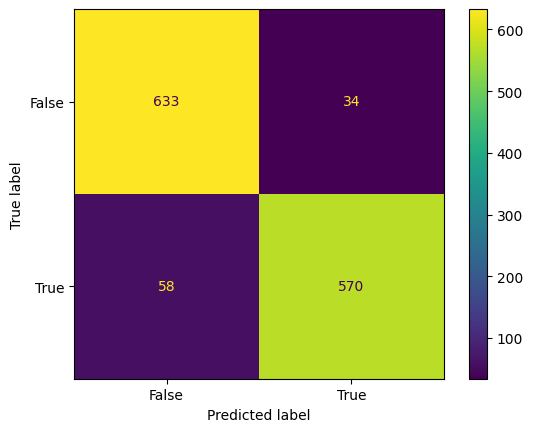

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate and display confusion matrix
ConfusionMatrixDisplay.from_predictions(test_y, preds)
plt.show()

In [29]:
import pandas as pd

print("Distribution of actual labels in the test set:")
print(pd.Series(test_y.numpy()).value_counts())

Distribution of actual labels in the test set:
False    667
True     628
Name: count, dtype: int64


In [30]:
# load weights of best model
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

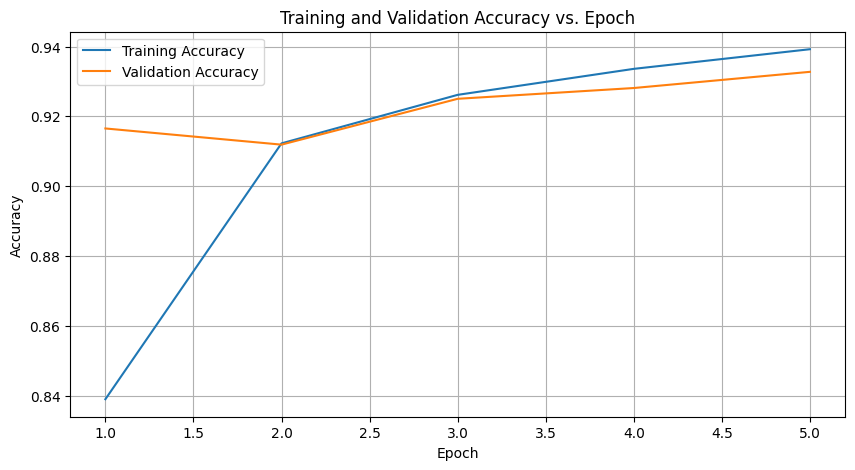

In [31]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
# Create an array for epoch numbers starting from 1
epochs_range = np.arange(1, len(train_accuracies) + 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

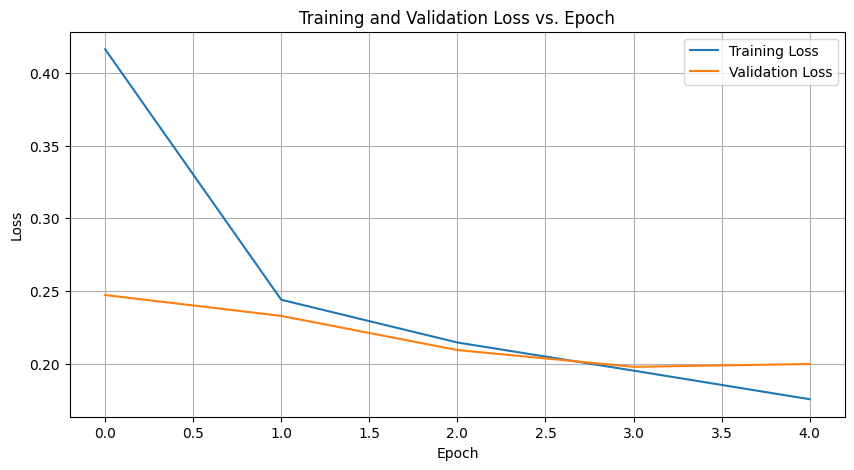

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Find the epoch with best validation loss
best_epoch_idx = valid_losses.index(min(valid_losses))
best_epoch_num = best_epoch_idx + 1

print("\n" + "="*60)
print("BEST MODEL STATISTICS (Early Stopping)")
print("="*60)
print(f"Best validation loss occurred at epoch: {best_epoch_num}")
print(f"Best validation loss: {min(valid_losses):.4f}")
print(f"Corresponding validation accuracy: {valid_accuracies[best_epoch_idx]:.4f}")
print(f"Corresponding training loss: {train_losses[best_epoch_idx]:.4f}")
print(f"Corresponding training accuracy: {train_accuracies[best_epoch_idx]:.4f}")
print(f"\nTraining stopped at epoch: {len(train_losses)} (early stopping triggered)")
print(f"Epochs saved by early stopping: {epochs - len(train_losses)}")
print("="*60)



BEST MODEL STATISTICS (Early Stopping)
Best validation loss occurred at epoch: 4
Best validation loss: 0.1980
Corresponding validation accuracy: 0.9281
Corresponding training loss: 0.1954
Corresponding training accuracy: 0.9336

Training stopped at epoch: 5 (early stopping triggered)
Epochs saved by early stopping: 0


In [34]:
# Load best model
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))
print("✓ Best model loaded")

# Move test data to GPU
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)

# Evaluate on test set
model.eval()
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)

# Print results
print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(classification_report(test_y, preds, target_names=['Real', 'Fake']))


✓ Best model loaded

TEST SET RESULTS
              precision    recall  f1-score   support

        Real       0.91      0.95      0.93       667
        Fake       0.94      0.90      0.92       628

    accuracy                           0.93      1295
   macro avg       0.93      0.93      0.93      1295
weighted avg       0.93      0.93      0.93      1295



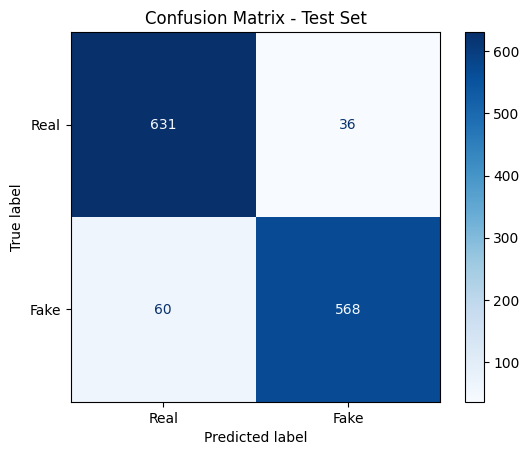

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(test_y, preds,
                                        display_labels=['Real', 'Fake'],
                                        cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()


In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(test_y, preds)

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
print(cm)
print("\n" + "="*60)
print("DETAILED METRICS FROM CONFUSION MATRIX")
print("="*60)

# Extract values from confusion matrix
# Format: [[TN, FP],
#          [FN, TP]]
TN = cm[0, 0]  # True Negatives (Real predicted as Real)
FP = cm[0, 1]  # False Positives (Real predicted as Fake)
FN = cm[1, 0]  # False Negatives (Fake predicted as Real)
TP = cm[1, 1]  # True Positives (Fake predicted as Fake)

print(f"\nTrue Negatives (TN):  {TN}  (Real correctly classified)")
print(f"False Positives (FP): {FP}  (Real misclassified as Fake)")
print(f"False Negatives (FN): {FN}  (Fake misclassified as Real)")
print(f"True Positives (TP):  {TP}  (Fake correctly classified)")

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision_fake = TP / (TP + FP)
recall_fake = TP / (TP + FN)
f1_fake = 2 * (precision_fake * recall_fake) / (precision_fake + recall_fake)

precision_real = TN / (TN + FN)
recall_real = TN / (TN + FP)
f1_real = 2 * (precision_real * recall_real) / (precision_real + recall_real)

print("\n" + "-"*60)
print("OVERALL METRICS")
print("-"*60)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Total Samples: {TP + TN + FP + FN}")
print(f"Correctly Classified: {TP + TN}")
print(f"Misclassified: {FP + FN}")

print("\n" + "-"*60)
print("PER-CLASS METRICS")
print("-"*60)
print(f"\nREAL NEWS:")
print(f"  Precision: {precision_real:.4f}")
print(f"  Recall:    {recall_real:.4f}")
print(f"  F1-Score:  {f1_real:.4f}")

print(f"\nFAKE NEWS:")
print(f"  Precision: {precision_fake:.4f}")
print(f"  Recall:    {recall_fake:.4f}")
print(f"  F1-Score:  {f1_fake:.4f}")

print("\n" + "-"*60)
print("ERROR ANALYSIS")
print("-"*60)
print(f"Real news misclassified as Fake: {FP} ({FP/667*100:.2f}% of real news)")
print(f"Fake news misclassified as Real: {FN} ({FN/628*100:.2f}% of fake news)")
print("="*60)
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(test_y, preds)

# Calculate accuracy
accuracy = np.trace(cm) / np.sum(cm)

print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")




CONFUSION MATRIX
[[631  36]
 [ 60 568]]

DETAILED METRICS FROM CONFUSION MATRIX

True Negatives (TN):  631  (Real correctly classified)
False Positives (FP): 36  (Real misclassified as Fake)
False Negatives (FN): 60  (Fake misclassified as Real)
True Positives (TP):  568  (Fake correctly classified)

------------------------------------------------------------
OVERALL METRICS
------------------------------------------------------------
Accuracy: 0.9259 (92.59%)
Total Samples: 1295
Correctly Classified: 1199
Misclassified: 96

------------------------------------------------------------
PER-CLASS METRICS
------------------------------------------------------------

REAL NEWS:
  Precision: 0.9132
  Recall:    0.9460
  F1-Score:  0.9293

FAKE NEWS:
  Precision: 0.9404
  Recall:    0.9045
  F1-Score:  0.9221

------------------------------------------------------------
ERROR ANALYSIS
------------------------------------------------------------
Real news misclassified as Fake: 36 (5.40% of